# Technical Test - Senior Software Engineer by CardNexus Report

Alixsep - December 11, 2024

This is a casual report about this technical test. I will try to be as clear as possible and I will try to explain my decisions and the reasons behind them. This wasn't asked but I think it's fun to share my thoughts.


## Overview of the overview of the test

> This test involves building a backend service that can:
>
> - Ingest data from two JSON files, each representing a different Trading Card Game (TCG): **Magic: The Gathering (MTG)** and **Lorcana**.
> - Store these cards in a unified data structure that allows flexible retrieval.
> - Provide an endpoint that returns cards from both games with the ability to filter by any of their attributes.
>
> You are free to choose your technology stack and approach. The key evaluation points will be the data modeling, query performance, and the flexibility of your filtering logic.

- _involves building a backend service_: so it's fullstack, but it seems that the focus is on the backend. (as it should be)
- _Ingest data from two JSON files_: this is a simple task, but it's important to do it right. I should see if the data is clean and if it's well structured.
- _Store these cards in a unified data structure_: this is the most important part of the test. I should think about how to store the data and how to query it.
- _Provide an endpoint that returns cards from both games with the ability to filter by any of their attributes_: this is the second most important part of the test. I should think about how to query the data and how to filter it.
- _You are free to choose your technology stack and approach_: this is great. For now I will go for what I'm used to, but I will try to think about other technologies that could be better for this task.
- _The key evaluation points will be the_:
  - _data modeling, query performance_: I'm thinking of setting up benchmarks for measuring the performance of the queries. Also the queries should be optimized. Actually, not just queries? but the combination of the data structure and the queries working together.
  - _flexibility of your filtering logic_: I'll have these in my mind while I'm designing the filtering logic: multiple filter queries, range queries, partial matches, logical operators, support for unknown attributes, ease of extendibility, and uhhh, for now I think these are good starting points.


## Overview of data files

> You can download the two source data files here :
>
> - https://cardnexus-hiring-docs.s3.eu-west-1.amazonaws.com/lorcana-cards.json
> - https://cardnexus-hiring-docs.s3.eu-west-1.amazonaws.com/mtg-cards.json

Ok ok 😃, let's do it now!

```bash
wget https://cardnexus-hiring-docs.s3.eu-west-1.amazonaws.com/lorcana-cards.json
wget https://cardnexus-hiring-docs.s3.eu-west-1.amazonaws.com/mtg-cards.json
```

I will take a look at the data files now.

_Command_:

```bash
ll -h
```

_Output_:

```text
...
-rwxrwxrwx 1 alix alix 142K Dec 10 20:17 lorcana-cards.json*
-rwxrwxrwx 1 alix alix 3.1M Dec 10 20:17 mtg-cards.json*
...
```

The Json files seem pretty small, but I should keep in mind that the data might grow in the future. I might need to have pagination in mind. before going further, I want to check if the JSON files are valid (for example, in terms of utf-8 encoding, syntax, etc).

_Command_:

```bash
file lorcana-cards.json
file mtg-cards.json
```

_Output_:

```text
lorcana-cards.json: Unicode text, UTF-8 text
mtg-cards.json: Unicode text, UTF-8 text
```

_Command_:

```bash
python3 -mjson.tool ./lorcana-cards.json > /dev/null
python3 -mjson.tool ./mtg-cards.json > /dev/null
```

No errors (No output), that's good.

> 1. **mtg-cards.json**
>
>    Each object will have the following fields:
>
>    - **id**: A unique identifier for the card.
>    - **name**: A text field with the card’s name.
>    - **rarity**: An enum-like text field representing the card’s rarity (with rarity values specific to MTG). Possible values : `common`, `mythic`, `rare`, `special` , `uncommon`
>    - **color**: An enum-like text field. This field is optional and, when present, can be one of `U` (Blue), `B` (Black), `G` (Green), `R` (Red), or `W` (White).
>
> 2. **lorcana-cards.json**
>
>    Each object will have the following fields:
>
>    - **id**: A unique identifier for the card.
>    - **name**: A text field with the card’s name.
>    - **rarity**: An enum-like text field representing the card’s rarity (with rarity values specific to Lorcana). Possible values : `Common`, `Enchanted`, `Legendary`, `Promo`, `Rare`, `Super Rare`, `Uncommon`
>    - **ink_cost**: A numeric field representing the card’s resource cost.
>
> It is up to you how to store and query those attributes efficiently.

Woah that's too much information. Let's break it down:

- _Each object will have the following fields_: AHAHA for some reason I think there might be surprises in the data files. 😃😃😃
- _id_: a unique identifier for the card. I might use this as the primary key. Two things to consider, the uniqueness of the id and the type of the id. also I will need to check if the id is present in all the cards. I will also need to check if ids are unique across the two files as they should not collide. If they do, I will need to think about how to handle this. I either need to generate new ids or use a composite key, for example, the id and the game name or card name.
- _name_: I will need to check if the name is present in all the cards. I will also need to think about what to do if the names are not unique across the two files, or after when possible extra data gets added to the database. Not only it could possibly happen, but I believe it's very unlikely that it would NOT happen.
- _rarity_: Very interesting field. I need to figure out what rarity values specific to MTG and Lorcana are. It's interesting because the values are not consistent, "common" and "Common" could be mistakenly considered as different values if not careful. (btw what is "uncommon"? lol isn't it "rare"? 😃)
- _color_: U for bl**U**e.
- _ink\_cost_: I don't know what this is, I might need to see the ranges though.
- _It is up to you how to store and query those attributes efficiently_: "efficiently"? in terms of time complexity? space complexity? or both? I will do my best to keep both in mind.


In [1]:
import * as fs from "node:fs";

/**
 * Reads a JSON file and returns the parsed data.
 *
 * @param filePath - The path to the JSON file.
 * @returns The parsed JSON data.
 *
 * @throws Will throw an error if the file cannot be read or if the JSON is invalid.
 *
 * @example
 * ```typescript
 * const data = readJsonFile('/path/to/data.json');
 * ```
 */
const readJsonFile = (filePath: string): any => {
  try {
    const data = fs.readFileSync(filePath, "utf8");
    return JSON.parse(data);
  } catch (error) {
    throw new Error(`Error reading the JSON file: ${error.message}`);
  }
};


In [2]:
/**
 * Analyzes a JSON object containing an array of objects and logs a detailed report.
 *
 * @param objects - The JSON object to analyze.
 *
 * @example
 * ```typescript
 * const data = readJsonFile('/path/to/data.json');
 * analyzeJsonObject(data);
 * ```
 */
const analyzeJsonObject = (objects: any[]): void => {
  // Check if the data is an array
  if (!Array.isArray(objects)) {
    console.error(
      `Error analyzing the JSON object: The JSON object does not contain an array of objects.`
    );
    return;
  }

  // Initialize analysis results
  const uniqueKeys = new Set<string>();
  const keyFrequency: Record<string, number> = {};
  const keyValueTypes: Record<string, Set<string>> = {};

  // Analyze each object in the array
  objects.forEach((obj, index) => {
    if (typeof obj !== "object" || obj === null) {
      console.warn(`Warning: Item at index ${index} is not an object.`);
      return;
    }

    Object.entries(obj).forEach(([key, value]) => {
      // Track unique keys
      uniqueKeys.add(key);

      // Track key frequency
      keyFrequency[key] = (keyFrequency[key] || 0) + 1;

      // Track value types for each key
      const valueType = Array.isArray(value) ? "array" : typeof value;
      if (!keyValueTypes[key]) {
        keyValueTypes[key] = new Set();
      }
      keyValueTypes[key].add(valueType);
    });
  });

  // Log analysis results
  console.log("Data Analysis Report:");
  console.log("=====================");
  console.log(`Total Records: ${objects.length}`);
  console.log(`Unique Keys: ${Array.from(uniqueKeys).join(", ")}`);

  // Prepare data
  const tableData = Array.from(uniqueKeys).map((key) => ({
    Key: key,
    Frequency: keyFrequency[key] || 0,
    "Value Types": Array.from(keyValueTypes[key] || []).join(", "),
  }));

  // Log the table
  console.table(tableData);
};


In [3]:
const lorcanaCards = readJsonFile("./apps/server/src/json/lorcana-cards.json");
const mtgCards = readJsonFile("./apps/server/src/json/mtg-cards.json");

console.log("lorcana-cards.json:");
analyzeJsonObject(lorcanaCards);

console.log("mtg-cards.json:");
analyzeJsonObject(mtgCards);


lorcana-cards.json:
Data Analysis Report:
Total Records: 1255
Unique Keys: name, ink_cost, rarity, id
┌───────┬────────────┬───────────┬─────────────┐
│ (idx) │ Key        │ Frequency │ Value Types │
├───────┼────────────┼───────────┼─────────────┤
│     0 │ "name"     │      1255 │ "string"    │
│     1 │ "ink_cost" │      1255 │ "number"    │
│     2 │ "rarity"   │      1255 │ "string"    │
│     3 │ "id"       │      1255 │ "string"    │
└───────┴────────────┴───────────┴─────────────┘
mtg-cards.json:
Data Analysis Report:
Total Records: 29883
Unique Keys: color, name, rarity, id
┌───────┬──────────┬───────────┬─────────────┐
│ (idx) │ Key      │ Frequency │ Value Types │
├───────┼──────────┼───────────┼─────────────┤
│     0 │ "color"  │     26763 │ "string"    │
│     1 │ "name"   │     29883 │ "string"    │
│     2 │ "rarity" │     29883 │ "string"    │
│     3 │ "id"     │     29883 │ "string"    │
└───────┴──────────┴───────────┴─────────────┘


I can see some the data is pretty clean, every card has its id and name. The types are also consistent. Let's see what the values for rarity, color, and ink_cost are.

In [4]:
/**
 * Analyzes specific fields in a JSON object containing an array of objects and logs a detailed report.
 * This function allows you to specify the fields you want to analyze.
 *
 * @param objects - The JSON object to analyze.
 * @param fields - The fields to analyze.
 *
 * @example
 * ```typescript
 * const data = readJsonFile('/path/to/data.json');
 * analyzeSpecificFields(data, ['field1', 'field2']);
 * ```
 */
const analyzeSpecificFields = (objects: any[], fields: string[]): void => {
  // Check if the data is an array
  if (!Array.isArray(objects)) {
    console.error(
      "Error analyzing the JSON object: The JSON object does not contain an array of objects."
    );
    return;
  }

  // Initialize analysis results
  const fieldValues: Record<string, Record<any, number>> = {};

  // Initialize frequency counters for each field
  fields.forEach((field) => {
    fieldValues[field] = {};
  });

  // Analyze each object in the array
  objects.forEach((obj) => {
    if (typeof obj !== "object" || obj === null) {
      return;
    }

    fields.forEach((field) => {
      if (obj[field] !== undefined) {
        const value = obj[field];
        fieldValues[field][value] = (fieldValues[field][value] || 0) + 1;
      }
    });
  });

  // Log analysis results in a table format
  fields.forEach((field) => {
    console.log(`Analysis of field: ${field}`);
    console.log("=====================");
    const tableData = Object.entries(fieldValues[field]).map(
      ([value, frequency]) => ({
        Value: value,
        Frequency: frequency,
      })
    );
    console.table(tableData);
  });
};


In [5]:
console.log("lorcana-cards.json:");
analyzeSpecificFields(lorcanaCards, ["rarity", "ink_cost"]);

console.log("mtg-cards.json:");
analyzeSpecificFields(mtgCards, ["rarity", "color"]);


lorcana-cards.json:
Analysis of field: rarity
┌───────┬──────────────┬───────────┐
│ (idx) │ Value        │ Frequency │
├───────┼──────────────┼───────────┤
│     0 │ "Uncommon"   │       323 │
│     1 │ "Super Rare" │       108 │
│     2 │ "Common"     │       432 │
│     3 │ "Rare"       │       288 │
│     4 │ "Legendary"  │        72 │
│     5 │ "Enchanted"  │         1 │
│     6 │ "Promo"      │        31 │
└───────┴──────────────┴───────────┘
Analysis of field: ink_cost
┌───────┬───────┬───────────┐
│ (idx) │ Value │ Frequency │
├───────┼───────┼───────────┤
│     0 │ "0"   │         4 │
│     1 │ "1"   │       148 │
│     2 │ "2"   │       273 │
│     3 │ "3"   │       286 │
│     4 │ "4"   │       223 │
│     5 │ "5"   │       147 │
│     6 │ "6"   │        85 │
│     7 │ "7"   │        57 │
│     8 │ "8"   │        17 │
│     9 │ "9"   │        12 │
│    10 │ "10"  │         3 │
└───────┴───────┴───────────┘
mtg-cards.json:
Analysis of field: rarity
┌───────┬────────────┬─────

At first I thought "Enchanted" is an outlier, but I searched it and it seems to be a valid rarity. (Too rare for me to know 😃) But the thing is again I saw no anomaly, seems like the data is clean again. Now I feel safe to take a look at the actual data.

This is the first 5 cards from `mtg-cards.json`:

```json
[{
    "color": "G",
    "name": "\"Ach! Hans, Run!\"",
    "rarity": "rare",
    "id": "ach-hans-run-a2c5ee76"
  },
  {
    "color": "B",
    "name": "\"Brims\" Barone, Midway Mobster",
    "rarity": "uncommon",
    "id": "brims-barone-midway-mobster-c64c31f2"
  },
  {
    "color": "G",
    "name": "A Killer Among Us",
    "rarity": "uncommon",
    "id": "a-killer-among-us-79d577a8"
  },
  {
    "color": "U",
    "name": "Academy Drake",
    "rarity": "common",
    "id": "academy-drake-65f3ebeb"
  },
  {
    "color": "R",
    "name": "Arc Mage",
    "rarity": "uncommon",
    "id": "arc-mage-011bb6cc"
  }]
```

This is the first 5 cards from `lorcana-cards.json`:

```json
[{
    "name": "Ariel - On Human Legs",
    "ink_cost": 4,
    "rarity": "Uncommon",
    "id": "ariel-on-human-legs"
  },
  {
    "name": "Ariel - Spectacular Singer",
    "ink_cost": 3,
    "rarity": "Super Rare",
    "id": "ariel-spectacular-singer"
  },
  {
    "name": "Maximus - Relentless Pursuer",
    "ink_cost": 3,
    "rarity": "Uncommon",
    "id": "maximus-relentless-pursuer"
  },
  {
    "name": "Dr. Facilier's Cards",
    "ink_cost": 2,
    "rarity": "Uncommon",
    "id": "dr-faciliers-cards"
  },
  {
    "name": "Basil - Practiced Detective",
    "ink_cost": 1,
    "rarity": "Common",
    "id": "basil-practiced-detective"
  }]
```

Looking at them both, I instantly noticed how id includes parts of the name. I think this is a good idea to make the ids more human-readable. but I should check if there is a consistent pattern for this. Seems like they have converted the names to kebab-case and removed the special characters. I will check if this is the case for all the cards. but in `mtg-cards.json` I see that they have also added a random string at the end of the id. I will check if this is the case for all the cards. I will also check if the ids are unique.
About the rarities, I will keep an eyes of letter casing.


In [6]:
/**
 * Validates the IDs of the cards and checks for uniqueness.
 *
 * @param objects - The JSON object to analyze.
 * @param idPattern - The regex pattern that the IDs should follow.
 *
 * @example
 * ```typescript
 * const data = readJsonFile('/path/to/data.json');
 * validateIds(data, /^[a-z0-9-]+$/);
 * ```
 */
const validateIds = (objects: any[], idPattern: RegExp): void => {
    const idSet = new Set<string>();
    let allValid = true;

    objects.forEach((obj, index) => {
        const id = obj.id;
        if (!id) {
            console.error(`Error: Missing ID at index ${index}`);
            allValid = false;
            return;
        }

        if (!idPattern.test(id)) {
            console.error(`Error: Invalid ID format at index ${index} - ${id}`);
            allValid = false;
        }

        if (idSet.has(id)) {
            console.error(`Error: Duplicate ID found at index ${index} - ${id}`);
            allValid = false;
        } else {
            idSet.add(id);
        }
    });

    if (allValid) {
        console.log("All IDs are valid and unique.");
    }
};

// Define the ID patterns for each dataset
const lorcanaIdPattern = /^[a-z0-9-]+$/;
const mtgIdPattern = /^[a-z0-9-]+-[a-z0-9]+$/;

console.log("Validating IDs in lorcana-cards.json:");
validateIds(lorcanaCards, lorcanaIdPattern);

console.log("Validating IDs in mtg-cards.json:");
validateIds(mtgCards, mtgIdPattern);

Validating IDs in lorcana-cards.json:
All IDs are valid and unique.
Validating IDs in mtg-cards.json:


Error: Invalid ID format at index 22078 - -4e536142


Well well well, I see some surprises here. 👀 Let me see the object with id `-4e536142`:

```json
{
  "color": "U",
  "name": "_____",
  "rarity": "uncommon",
  "id": "-4e536142"
}
```

Oh boy, the name is `_____`, I should check if there are more cards like this.

Oops, there is:

```json
{
  "name": "_____ _____ Rocketship",
  "rarity": "uncommon",
  "id": "rocketship-1009f979"
},
{
  "color": "U",
  "name": "_____ _____ _____ Trespasser",
  "rarity": "uncommon",
  "id": "trespasser-75854e14"
},
{
  "color": "G",
  "name": "_____-o-saurus",
  "rarity": "common",
  "id": "o-saurus-32921952"
}
```

I might have to take a deeper look at the name and id specifically, I want to find a pattern. Let's see if for every card in `lorcana-cards.json`, the id is basically the name in kebab-case

In [7]:
import _ from "npm:lodash";
import slugify from "npm:slugify";

/**
 * Checks if the ID of each card in the dataset is the kebab-case version of its name.
 *
 * @param objects - The JSON object to analyze.
 *
 * @example
 * ```typescript
 * const data = readJsonFile('/path/to/data.json');
 * validateIdAsKebabCaseName(data);
 * ```
 */
const validateIdAsKebabCaseName = (objects: any[]): void => {
  const results = [];

  objects.forEach((obj, index) => {
    const id = obj.id;
    const name = obj.name;

    // Preprocess the name to generate the kebab-case version
    const preprocessedName = slugify(name, { lower: true, strict: true });

    // generate the kebab-case version of the name
    const generatedId = _.kebabCase(preprocessedName);

    if (id !== generatedId) {
      results.push({
        Index: index,
        Name: name,
        "Original ID": id,
        "Generated ID": generatedId,
      });
    }
  });

  if (results.length === 0) {
    console.log("All IDs match the kebab-case version of their names.");
  } else {
    console.log("Errors found:");
    console.table(results);
  }
};

console.log("Validating IDs as kebab-case names in lorcana-cards.json:");
validateIdAsKebabCaseName(lorcanaCards);


Validating IDs as kebab-case names in lorcana-cards.json:
All IDs match the kebab-case version of their names.


Alright it seems like I found the pattern. Let's see if in the `mtg-cards.json` the id follows the same pattern after excluding the random string at the end.

In [8]:
const mtgCardsWithModifiedIds = mtgCards.map((card) => ({
  ...card,
  id: card.id.split("-").slice(0, -1).join("-"), // chop off the last part of id
}));

console.log("Validating IDs as kebab-case names in lorcana-cards.json:");
validateIdAsKebabCaseName(mtgCardsWithModifiedIds);


Validating IDs as kebab-case names in lorcana-cards.json:
Errors found:
┌───────┬───────┬────────────────────────┬───────────────────────┬────────────────────────┐
│ (idx) │ Index │ Name                   │ Original ID           │ Generated ID           │
├───────┼───────┼────────────────────────┼───────────────────────┼────────────────────────┤
│     0 │ 24926 │ "D00-DL, Caricaturist" │ "d00-dl-caricaturist" │ "d-00-dl-caricaturist" │
└───────┴───────┴────────────────────────┴───────────────────────┴────────────────────────┘


So it's only one error that could be fixed by treating numbers as normal characters. Now, let's see if the ids collide across the two files.

In [9]:
/**
 * Checks for ID collisions between two datasets.
 *
 * @param dataset1 - The first dataset to analyze.
 * @param dataset2 - The second dataset to analyze.
 *
 * @example
 * ```typescript
 * const data1 = readJsonFile('/path/to/lorcana-cards.json');
 * const data2 = readJsonFile('/path/to/mtg-cards.json');
 * checkIdCollisions(data1, data2);
 * ```
 */
const checkIdCollisions = (dataset1: any[], dataset2: any[]): void => {
    const idSet = new Set<string>();
    const collisions = [];

    dataset1.forEach((obj) => {
        if (idSet.has(obj.id)) {
            collisions.push(obj.id);
        } else {
            idSet.add(obj.id);
        }
    });

    dataset2.forEach((obj) => {
        if (idSet.has(obj.id)) {
            collisions.push(obj.id);
        } else {
            idSet.add(obj.id);
        }
    });

    if (collisions.length === 0) {
        console.log("No ID collisions found between the two datasets.");
    } else {
        console.log("ID collisions found:");
        console.table(collisions);
    }
};

console.log("Checking for ID collisions between lorcana-cards.json and mtg-cards.json:");
checkIdCollisions(lorcanaCards, mtgCardsWithModifiedIds);

Checking for ID collisions between lorcana-cards.json and mtg-cards.json:
ID collisions found:
┌───────┬──────────────────────────────┐
│ (idx) │ Values                       │
├───────┼──────────────────────────────┤
│     0 │ "glimpse-the-unthinkable"    │
│     1 │ "helping-hand"               │
│     2 │ "ineffable-blessing"         │
│     3 │ "ineffable-blessing"         │
│     4 │ "ineffable-blessing"         │
│     5 │ "ineffable-blessing"         │
│     6 │ "ineffable-blessing"         │
│     7 │ "knight-of-the-kitchen-sink" │
│     8 │ "knight-of-the-kitchen-sink" │
│     9 │ "knight-of-the-kitchen-sink" │
│    10 │ "knight-of-the-kitchen-sink" │
│    11 │ "knight-of-the-kitchen-sink" │
│    12 │ "lash-out"                   │
│    13 │ "last-stand"                 │
│    14 │ "last-ditch-effort"          │
│    15 │ "launch"                     │
│    16 │ "lava-axe"                   │
│    17 │ "lightning-storm"            │
│    18 │ "lost-in-the-woods"          │
│  

Interesting... Not only we have collisions, but it seems we have duplicate ids in the same file as well. One example is:

```json
{
  "color": "B",
  "name": "Glimpse the Unthinkable",
  "rarity": "rare",
  "id": "glimpse-the-unthinkable-552f0163"
},
{
  "color": "B",
  "name": "Glimpse, the Unthinkable",
  "rarity": "rare",
  "id": "glimpse-the-unthinkable-ab6b0048"
},
```

Aside from the random string at the end, the ids are the same. Just as I was typing this, I noticed the names differ by only one comma. I need to search this right now.

_After searching_:
Guess they are different???

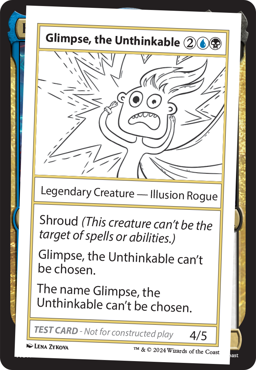
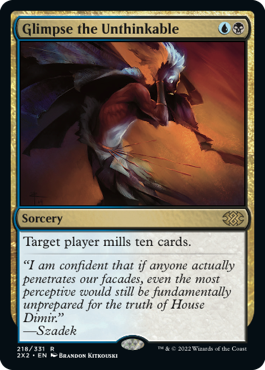

## Overview of requirements

> 1. **Data Ingestion**:
>
>    Read the two JSON files and store their contents in a database or in-memory structure. The choice of persistence layer, indexing, and data model is up to you. Consider future scalability and queries across attributes.
>
> 2. **Unified Endpoint**:
>
>    Implement a single endpoint that returns cards from both games.
>
>    - It should support filtering by any attribute present in the ingested data - or by game name
>    - Filtering should be flexible and capable of handling:
>      - Partial text matches for fields like `name`.
>      - One or more selected values for enum-like attributes such as `rarity` or `color`.
>      - Numeric comparisons (e.g., ranges) for fields like `ink_cost`.
>
> 3. **Flexibility & Extensibility**:
>
>    Your solution should be designed with extensibility in mind. Consider that new games or attributes may be added in the future. The code should allow easy integration of additional filters without significant refactoring.
>
> 4. **Performance & Indexing**:
>
>    Consider indexing or query optimization strategies. The test dataset may be small, but your approach should scale to larger datasets.

Alright let's go for it, for this challenge I am given the freedom to choose my stack however I want, I want to choose something that is reasonable in terms of balance between simplicity and over-engineering. I will use this stack:
- TypeScript _for type safety_
- Express.js _for API routing_
- MongoDB _for flexible document storage_
- Mongoose _for schema definition and validation_
- React _for frontend_
- Tailwind CSS _for styling_
- Vitest _for frontend testing_
- Pnpm _for package management_
